In [1]:
!pip install timesynth
# TIMESYNTH TO GENERATE TIME SERIESES
import ts_syntheticData
# CUSTOM DEFINED DATALOADERS AND MODELS
from ts_dataloader import get_train_valid_test_signals
from ts_training import train_network
from ts_VI_LSTM import Variational_LSTM, loss_normal2d
from ts_simple_LSTM_net import Standard_LSTM, loss_function_normal
from ts_anomaly_function import detect_anomalies
# PYTORCH
import torch
from torch import optim, distributions
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
# MATPLOTLIB NUMPY
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np


(1000, 1)
Dataset created.


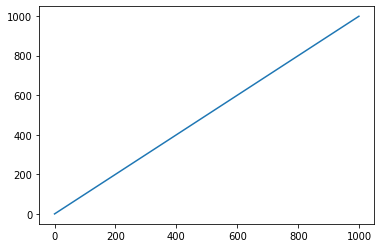

In [2]:
#USEDATASET = 0  # simple synthetic dataset
#USEDATASET = 1 # correlated synthetic dataset
USEDATASET = 2 # realistic weather dataset

# %% set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# number of samples in the time series
train_T = 1000
valid_T = 250
test_T = 250
# width of the window of each time series
W = 1000
# check for inconsistency
if W > train_T:
    raise ValueError("The time window cannot be longer than the training data sequence available.")

T = train_T + valid_T + test_T
# the size of train and validation, test is the remainder of the data
t_v_t_split = [train_T/T,valid_T/T]

#load the data in, this is supposed to happen only once
features, train_dataset, valid_dataset, test_dataset = get_train_valid_test_signals(T, W, USEDATASET, t_v_t_split, device)


print(train_dataset.get_data()[0].shape)

train_timeseries_signals = train_dataset.get_data()[0]
plt.plot(list(range(len(train_timeseries_signals))), train_timeseries_signals)
plt.show()


In [3]:
# Here we can change to batch size
# batch size (number of serieses of length W)
B = 1
# check for consistency, we don't want to pad the sequence if possible
if (train_T - W + 1) % B != 0 :
    raise ValueError("The batch size chosen will result in different sized batches during training")

# create the Synthetic Dataset
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False)
#valid_loader = DataLoader(valid_dataset, shuffle=False)
#seq_loader = DataLoader(valid_dataset, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Starting training
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


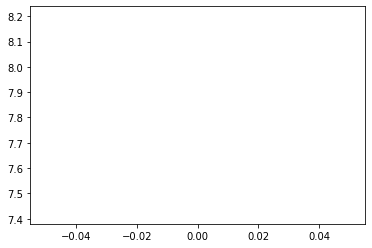

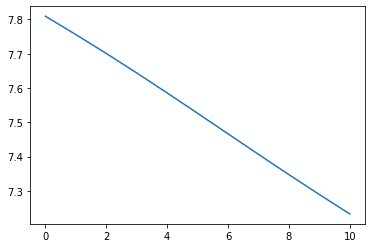

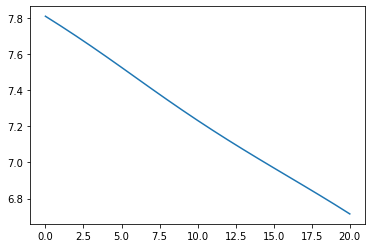

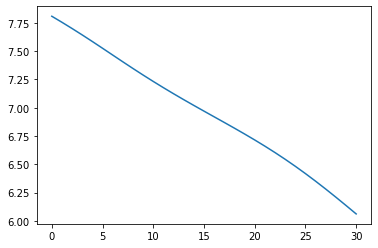

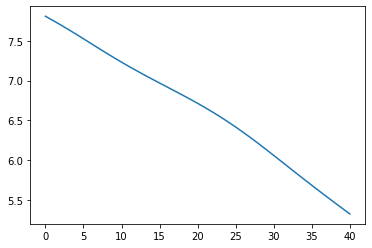

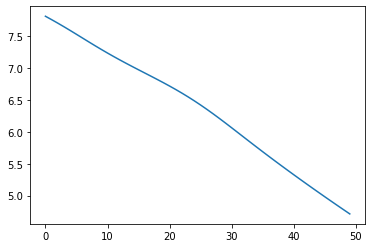

In [4]:
epochs = 100
params_distribution = 2
hidden_dim_gen = 256
hidden_dim_rec = 256
latent_dim = 8

#define the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_normal2d
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)


#run the training
net_state_dict = train_network(device, train_loader, None, epochs, net, loss_function, optimizer, scheduler = scheduler)

Starting training
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


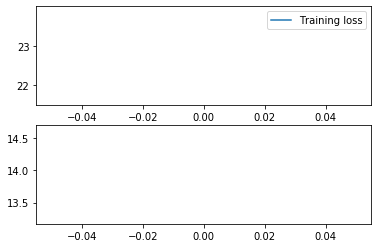

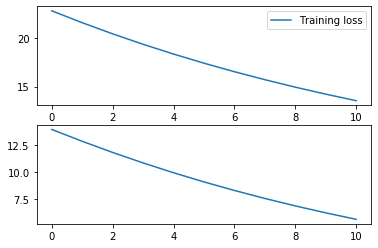

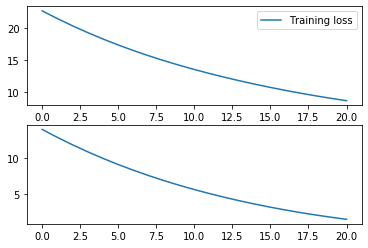

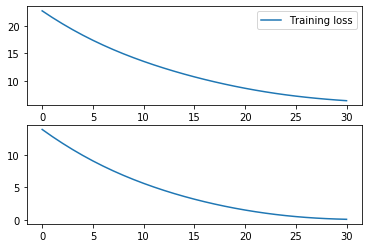

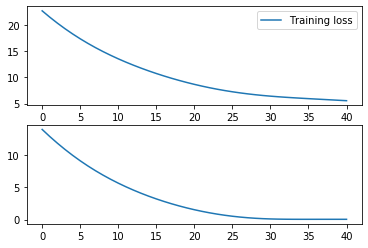

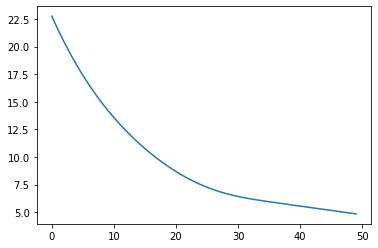

In [4]:
epochs = 300
params_distribution = 2
hidden_layer_size = 128

#define the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_function_normal
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.0001)

scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

#here define eventual scheduler

#run the training
net_state_dict = train_network(device, train_loader, None, epochs, net, loss_function, optimizer, scheduler= scheduler)

In [11]:
# start time of plotting
A = 0
# end time of plotting
B = 1000
# select the sequence to test the network on
sequence = valid_dataset.get_data()[0]
with torch.no_grad():
    # load the state of the trained network
    net.load_state_dict(net_state_dict)    
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        plt.show()

    

<All keys matched successfully>

In [ ]:
detect_anomalies(sequence)
